In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
file_path = 'tickets_movidesk_urgencia.xlsx'

try:
    df = pd.read_excel(file_path)
    print("Arquivo lido com sucesso!")
except FileNotFoundError:
    print(f"ERRO: Arquivo não encontrado no caminho especificado: {file_path}")
    print("Por favor, verifique se o caminho do arquivo está correto e se o Google Drive está montado.")
except Exception as e:
    print(f"Ocorreu um erro ao ler o arquivo: {e}")

Arquivo lido com sucesso!


In [3]:
df.dropna(subset=['Urgência', 'Texto Inicial'], inplace=True)
df = df[df['Urgência'].isin(['Urgente', 'Alta', 'Média', 'Baixa'])]
df.head(12)

,ID,Assunto,Data de Criação,Serviço,Categoria,Urgência,Status,Solicitante,Texto Inicial
0,67400,Erro impressão relatórios,2025-05-30 10:06:56,Totvs Protheus > Geral > Contas e Acessos,Problema,Baixa,Fechado,Mateus Junqueira Freitas Rodovalho,"Bom dia pessoal,\n\nUsuário ernani.napomuceno ..."
1,67379,Exclusão de Documento de Entrada,2025-05-29 16:36:53,Totvs Protheus > Geral > Contas e Acessos,Dúvida,Média,Fechado,Kawan Kelvin Carvalho da Silva,Boa tarde!\n\nGostaria de saber se tem alguma ...
2,67363,EVENTO S-2299 REJEITADO,2025-05-29 11:27:28,Totvs Protheus > RH > TAF Esocial (SIGATAF),Problema,Média,Fechado,Gabrielle Monteiro Machado,Bom dia!\n\nSolicito auxilio para resolver eve...
3,67350,Conciliador com Movimentação de Pedágio Indepe...,2025-05-29 10:01:51,Totvs Protheus > Geral > Financeiro (SIGAFIN),Solicitação,Média,Fechado,Luciane Nunes da Silva,"Bom dia!\n\nPor favor, excluir a movimentação ..."
4,67343,Criação Titulo,2025-05-29 08:58:31,Totvs Protheus > RH > Gestão de Pessoal (SIGAGPE),Solicitação,Baixa,Fechado,RAYSSA DE SOUZA QUEIROZ,Bom dia!\nGostaria que fosse criado o titulo p...
5,67330,COMPENSAÇÃO BANCO DE HORAS,2025-05-28 15:51:16,Totvs RM > RH > Automação de Ponto,Problema,Média,Fechado,Isabella Oliveira do Nascimento,Boa tarde!\n\nNão estou conseguindo realizar a...
6,67329,030315 - Solicitação Parametrização - Emissão ...,2025-05-28 15:27:52,Totvs Protheus > Geral > Compras (SIGACOM),Problema,Urgente,Fechado,Francielly Carvalho,"Boa tarde!\n\nPrezados (as),\n\n\nPor gentilez..."
7,67328,valor duplicado na conciliação,2025-05-28 15:25:45,Totvs Protheus > Geral > Financeiro (SIGAFIN),Problema,Alta,Fechado,Nubia Borges Ferreira,"Boa tarde, favor excluir baixas flegadas ( val..."
8,67320,Reabrir Ordem de Produção,2025-05-28 14:41:59,Totvs Protheus > Materiais > Estoque/Custos (S...,Problema,Média,Fechado,Samuel Saymon Silva,"Favor, solicito a reabertura das ordens de pro..."
9,67305,"Urgente - Inclusão de lançamento contábil, com...",2025-05-28 11:34:02,Totvs Protheus > Controladoria > Contabilidade...,Problema,Média,Fechado,Eucrides Junior,"Bom dia!\n\nMesmo após rodar a rotina de ""Ence..."


In [5]:
def limpar_texto(texto):
    texto = str(texto).lower()  
    texto = re.sub(r'\b(bom dia|boa tarde|olá|tudo bem|att|obrigado).*?\b', '', texto)
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

In [8]:
# Aplicar limpeza no texto inicial e no assunto
df['Texto Inicial Limpo'] = df['Texto Inicial'].apply(limpar_texto)
df['Assunto Limpo'] = df['Assunto'].apply(limpar_texto)

# Recriar coluna combinada com os textos limpos
#df['TextoCombinado'] = df['Texto Inicial Limpo'] + ' ' + df['Assunto Limpo'] + ' ' + df['Categoria'].fillna('') + ' ' + df['Serviço'].fillna('')
#df['TextoCombinado'] = df['Texto Inicial Limpo'] + ' ' + df['Categoria'].fillna('') + ' ' + df['Serviço'].fillna('')

# Codificar os rótulos de urgência
label_map = {'Baixa': 0, 'Média': 1, 'Alta': 2, 'Urgente': 3}
df['Urgência_Label'] = df['Urgência'].map(label_map)

urgencia_counts = df['Urgência'].value_counts()
urgencia_percent = df['Urgência'].value_counts(normalize=True) * 100

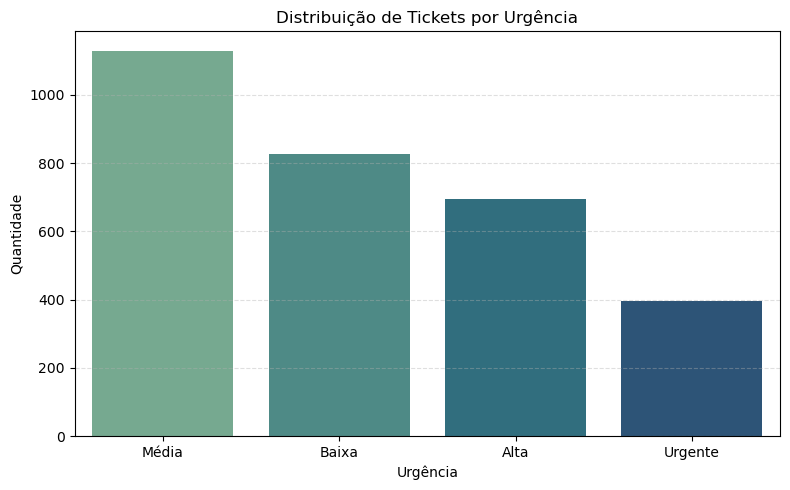

In [9]:
# Plot: Contagem por urgência
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Urgência', order=urgencia_counts.index, palette='crest')
plt.title('Distribuição de Tickets por Urgência')
plt.xlabel('Urgência')
plt.ylabel('Quantidade')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [10]:
df.head()

,ID,Assunto,Data de Criação,Serviço,Categoria,Urgência,Status,Solicitante,Texto Inicial,Texto Inicial Limpo,Assunto Limpo,Urgência_Label
0,67400,Erro impressão relatórios,2025-05-30 10:06:56,Totvs Protheus > Geral > Contas e Acessos,Problema,Baixa,Fechado,Mateus Junqueira Freitas Rodovalho,"Bom dia pessoal,\n\nUsuário ernani.napomuceno ...",pessoal usuário ernaninapomuceno relatou que n...,erro impressão relatórios,0
1,67379,Exclusão de Documento de Entrada,2025-05-29 16:36:53,Totvs Protheus > Geral > Contas e Acessos,Dúvida,Média,Fechado,Kawan Kelvin Carvalho da Silva,Boa tarde!\n\nGostaria de saber se tem alguma ...,gostaria de saber se tem alguma configuração q...,exclusão de documento de entrada,1
2,67363,EVENTO S-2299 REJEITADO,2025-05-29 11:27:28,Totvs Protheus > RH > TAF Esocial (SIGATAF),Problema,Média,Fechado,Gabrielle Monteiro Machado,Bom dia!\n\nSolicito auxilio para resolver eve...,solicito auxilio para resolver evento s2299 re...,evento s2299 rejeitado,1
3,67350,Conciliador com Movimentação de Pedágio Indepe...,2025-05-29 10:01:51,Totvs Protheus > Geral > Financeiro (SIGAFIN),Solicitação,Média,Fechado,Luciane Nunes da Silva,"Bom dia!\n\nPor favor, excluir a movimentação ...",por favor excluir a movimentação deste pedágio...,conciliador com movimentação de pedágio indepe...,1
4,67343,Criação Titulo,2025-05-29 08:58:31,Totvs Protheus > RH > Gestão de Pessoal (SIGAGPE),Solicitação,Baixa,Fechado,RAYSSA DE SOUZA QUEIROZ,Bom dia!\nGostaria que fosse criado o titulo p...,gostaria que fosse criado o titulo para integr...,criação titulo,0
